# Librerias

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [8]:
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

seed = 42

# Lectura

In [3]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

## Preprocesado

In [4]:
min_max_scaler = MinMaxScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

for col in ['no_of_weekend_nights', 'year','day_of_week', 'no_of_special_requests']:
    min_max_scaler = MinMaxScaler()
    X_train_scaled[col] = min_max_scaler.fit_transform(X_train_scaled[[col]])
    X_test_scaled[col] = min_max_scaler.transform(X_test_scaled[[col]])

# Stacking

**Modelos base**

- Regresion logistica
- Random Forest
- MLP (redes neuronales)

**Meta modelo**

- Regresion logistica

### Modelos base lectura

In [5]:
import pickle
reg_log_model = pickle.load(open('../data/modelos/reg_log.pkl', 'rb'))
rf_model = pickle.load(open('../data/modelos/random_forest.pkl', 'rb'))
nn_model = pickle.load(open('../data/modelos/nn.pkl', 'rb'))

reg_log_model = reg_log_model.best_estimator_
rf_model = rf_model.best_estimator_
nn_model = nn_model.best_estimator_

### Meta modelo

In [53]:
level0 = list()
level0.append(("reg_log", reg_log_model))
level0.append(("random_forest", rf_model))
level0.append(("nn", nn_model))

level1 = LogisticRegression(random_state=seed)

stacking = StackingClassifier(estimators=level0,final_estimator=level1)

In [23]:
stacking

StackingClassifier(estimators=[('reg_log',
                                LogisticRegression(C=10, random_state=42,
                                                   solver='newton-cg')),
                               ('random_forest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_features='auto',
                                                       n_estimators=185,
                                                       random_state=42)),
                               ('nn',
                                MLPClassifier(hidden_layer_sizes=(78,),
                                              learning_rate_init=0.01,
                                              random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

# Resultados cross validation

In [54]:
kfold = KFold(n_splits=5,shuffle=True,random_state=seed)

results = cross_validate(
    stacking,
    X_train_scaled,
    y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', "f1", "roc_auc"],
    return_train_score=False,
    n_jobs=-1
)

results_stacking = pd.DataFrame(results)

In [55]:
mean_results = pd.DataFrame(results_stacking.mean(axis=0), columns=['test_cv'])
mean_results

,test_cv
fit_time,14.81
score_time,0.13
test_accuracy,0.85
test_precision,0.80
test_recall,0.72
test_f1,0.76
test_roc_auc,0.91


In [56]:
mean_results.to_csv('../data/cv_results/stacking.csv', index=False)

In [65]:
chart_results = pd.DataFrame([results_stacking['test_roc_auc'].values, results_stacking['test_recall'].values],index=['auc','recall']).T

<Figure size 720x432 with 0 Axes>

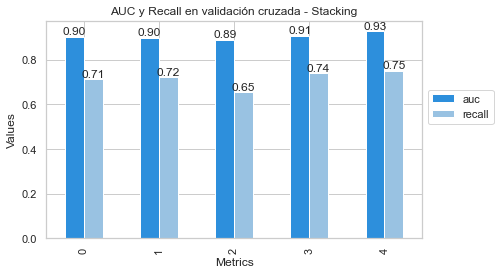

In [102]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a grouped barplot
sns.set(style="whitegrid")  # Optional: Set a white grid background
ax = chart_results.plot(kind='bar', color=['#2D8FDC', '#99C2E2'])

# Customize labels and title
ax.set(xlabel="Metrics", ylabel="Values", title="AUC y Recall en validación cruzada - Stacking")
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')
# Show the plot
plt.xticks(range(len(chart_results)), chart_results.index)

plt.show()

# Resultados test

In [28]:
stacking.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('reg_log',
                                LogisticRegression(C=10, random_state=42,
                                                   solver='newton-cg')),
                               ('random_forest',
                                RandomForestClassifier(criterion='entropy',
                                                       max_features='auto',
                                                       n_estimators=185,
                                                       random_state=42)),
                               ('nn',
                                MLPClassifier(hidden_layer_sizes=(78,),
                                              learning_rate_init=0.01,
                                              random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [29]:
preds = stacking.predict(X_test_scaled)
print(classification_report(y_test,preds))
print(roc_auc_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       603
           1       0.78      0.70      0.74       297

    accuracy                           0.84       900
   macro avg       0.82      0.80      0.81       900
weighted avg       0.83      0.84      0.83       900

0.8020754811799587


# Guardamos modelo y resultados

In [103]:
resultados_dict = {
    'AUC': roc_auc_score(y_test,preds),
    'Accuracy': accuracy_score(y_test,preds),
    'Recall': recall_score(y_test,preds),
    'Precision': precision_score(y_test,preds),
    'F1_score': f1_score(y_test,preds)
}

In [104]:
resultados = pd.DataFrame(resultados_dict,index=['Resultados en test']).T

In [105]:
resultados

,Resultados en test
AUC,0.80
Accuracy,0.84
Recall,0.70
Precision,0.78
F1_score,0.74


In [106]:
resultados.to_csv('../data/resultados/stacking.csv',index=False)

In [107]:
import pickle
pickle.dump(stacking, open('../data/modelos/stacking.pkl', 'wb'))